# Ranked Outcomes

This small workbook takes each set of outcomes across all genes for one target sequeunce and ranks them either according to their average frequency and standard deviation across all genes. The main outcome of this workbook shows that ranking by frequency or standard deviation doesn't really affect the ranking, so we can use either when filtering the outcomes to be informative.

Later will need to return to this workbook when we have choosen a better categorisation strategy.

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import sqlite3
from src.config import get_db_file, get_hussmann_supplementary_xlsx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.connect(get_db_file())
df = pd.read_sql_query('select Barcode, Gene, Alias, outcome, fraction_per_barcode from outcomes where Alias is "MB01"', con)
df_idx = df.set_index(["Alias", "Gene", "Barcode", "outcome"])
print("loaded outcomes")
print(df_idx.head(2))

num_genes = df_idx.index.get_level_values("Gene").unique().shape[0]
num_barcodes = df_idx.index.get_level_values("Barcode").unique().shape[0]
num_outcomes = df_idx.index.get_level_values("outcome").unique().shape[0]

print("We have {} unique barcodes covering {} genes, producing {} outcomes".format(num_barcodes, num_genes, num_outcomes))

loaded outcomes
                                                          fraction_per_barcode
Alias Gene          Barcode         outcome                                   
MB01  0610009B22Rik 0610009B22Rik-1 DELETION|-10|0||0bp               0.001243
                                    DELETION|-10|19||1bp              0.000355
We have 86569 unique barcodes covering 18363 genes, producing 514242 outcomes


In [3]:
df_idx_norm_mean = df_idx.groupby(level=["Alias", "Gene", "outcome"]).mean()
totals = df_idx_norm_mean[["fraction_per_barcode"]].sum(level="Gene")
df_idx_norm_mean = df_idx_norm_mean[["fraction_per_barcode"]].div(totals, level="Gene").droplevel(level="Alias")
print("Normalised per Gene")
# print(df_idx_norm_mean.head(2))

BASELINE_FREQUENCY = 0.002
frequent_outcomes = (df_idx_norm_mean.groupby("outcome").sum().div(num_genes)) > BASELINE_FREQUENCY
frequent_outcomes = frequent_outcomes[frequent_outcomes["fraction_per_barcode"]]
frequent_outcomes = frequent_outcomes.index
frequent_outcomes


df_idx_norm_mean_reduced = df_idx_norm_mean.loc[df_idx_norm_mean.index.get_level_values("outcome").isin(frequent_outcomes)]
totals = df_idx_norm_mean_reduced[["fraction_per_barcode"]].sum(level="Gene")
df_idx_norm_mean_reduced = df_idx_norm_mean_reduced[["fraction_per_barcode"]].div(totals, level="Gene")
print("Normalised frequent outcomes")
# print(df_idx_norm_mean_reduced.head(2))

df_outcome_profiles = df_idx_norm_mean_reduced.reset_index().pivot(index=["Gene"], columns="outcome", values="fraction_per_barcode").fillna(0)
df_outcome_profiles.index = df_outcome_profiles.index.str.lower()
print(df_outcome_profiles.iloc[:2, :3])
print("Repair outcome profiles created")

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_25893/2412254448.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx_norm_mean[["fraction_per_barcode"]].sum(level="Gene")


Normalised per Gene


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_25893/2412254448.py:15: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx_norm_mean_reduced[["fraction_per_barcode"]].sum(level="Gene")


Normalised frequent outcomes
outcome        DELETION|-10|2||1bp  DELETION|-10|5||3bp  DELETION|-10|6||2bp
Gene                                                                        
0610009b22rik             0.003722             0.006112             0.002530
0610010k14rik             0.004118             0.004862             0.004695
Repair outcome profiles created


In [4]:
all_means = df_idx_norm_mean.groupby("outcome").sum().div(num_genes)
df_idx_norm_deviation = df_idx_norm_mean.subtract(all_means, level="outcome")
df_idx_norm_deviation_sqrd = df_idx_norm_deviation.pow(2)
df_idx_norm_deviation_sqrd_summed = df_idx_norm_deviation_sqrd.groupby("outcome").sum()
df_idx_norm_deviation_var = df_idx_norm_deviation_sqrd_summed.div(num_genes)
df_idx_norm_sd = np.sqrt(df_idx_norm_deviation_var)
df_idx_norm_sd.head()

,fraction_per_barcode
outcome,
DELETION|-10|-1||3bp,0.001060
DELETION|-10|0||0bp,0.001116
DELETION|-10|100||0bp,0.000014
DELETION|-10|102||0bp,0.000020
DELETION|-10|103||0bp,0.000015


<AxesSubplot:xlabel='rank', ylabel='fraction_per_barcode'>

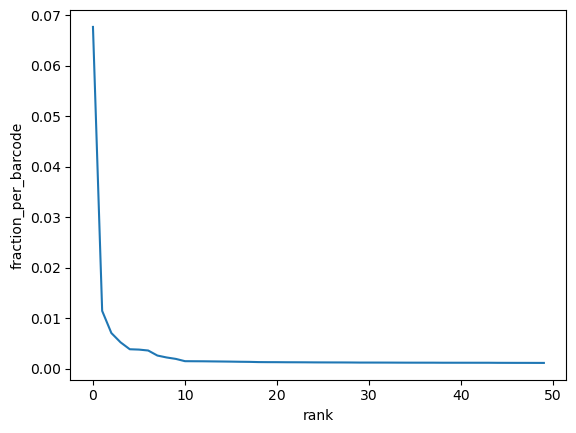

In [5]:
sd_plot = df_idx_norm_sd.sort_values(by="fraction_per_barcode", ascending=False).reset_index().head(50)
sd_plot["rank"] = list(sd_plot.index)
sns.lineplot(data=sd_plot, y="fraction_per_barcode", x="rank")

In [6]:
variable_outcomes = sd_plot.head(10)["outcome"]
np.intersect1d(frequent_outcomes, variable_outcomes).shape

(10,)